In [1]:
import mne

from sklearnex import patch_sklearn

patch_sklearn()

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 

import numpy as np
import os
from tqdm.auto import tqdm

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
output_dir = "/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/output"

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_generalizing_score(ax, scores, times, title, metric, scaling=None, chance=0.5, p=None, tail=0, verbose=False,
                            mask_mode="contour", interpolation='antialiased', n_jobs=None):
    """Plot generalizing searchlight analysis.
    Parameters
    ----------
    ax : matplotlib.pyplot.Axes
        Axes to use for plotting.
    scores : numpy.ndarray of shape (n_subjects, nd_computations, n_times, n_times)
        Scores of generalizing estimator for each subject. Subjects and computations are combined to compute variance.
    times : numpy.ArrayLike of shape n_times
        Timepoints used in analysis.
    title : str
        Title to use for the axes.
    metric : str
        Name of metric used for scoring.
    scaling : float, optional
        Scalings to use for plot. Will be calculated from data if set to None (default).
    chance : float, optional
        Baseline chance to use. 0.5 is used as default.
    p : float, optional
        Significance level to use for testing. No testing of significance if set to None (default).
    tail : typing.Literal[-1,0,1], optional
        Direction of significance testing. -1 indicates one-tailed test for under-performance, 0 indicates testing of
        both tails, and 1 is equivalent to -1 but for over-performance.
    verbose : bool, optional
        Verbosity. Set to False (default) to supress output.
    mask_mode : Literal["fill", "contour", "both"] : optional
        Masking mode for significance. Must be one of "contour" (default), "fill", or "both".
    interpolation : str, optional
        Interpolation to use for plot. See `matplotlib.pyplot.imshow` for interpolation modes.
    n_jobs : Union[Literal[-1], int, None], optional
        Number of parallel jobs to run, set to -1 to use all cores. Defaults to None, with results in single threading.
    Returns
    -------
        None
    """
    scores = scores.reshape((-1, scores.shape[-1], scores.shape[-1]))  # Combine all observations into one dimension.
    scores_mean = np.mean(scores, axis=0)
    assert mask_mode.lower().strip() in ["contour", "fill", "both"], ValueError(
        f'mask_mode must be one of "contour",  "fill", "both", not "{mask_mode}".')

    if scaling is None:
        scaling = np.max(np.abs(scores_mean - chance))

    # Compute significance levels
    if isinstance(p, float):
        _, clusters, cluster_p_values, _ = mne.stats.permutation_cluster_1samp_test(scores - chance, out_type='mask',
                                                                                    n_jobs=n_jobs, buffer_size=None,
                                                                                    n_permutations=1024,
                                                                                    threshold=None, tail=tail,
                                                                                    verbose=False)
        mask = np.zeros_like(scores_mean)
        for c, p_val in zip(clusters, cluster_p_values):
            if p_val <= p:
                verbose and print(f"Found cluster with p={p_val}")
                mask[c] = 1

        if mask_mode.lower().strip() in ["fill", "both"]:
            ax.imshow(scores_mean, interpolation=interpolation, origin='lower', cmap='gray',
                      extent=times[[0, -1, 0, -1]],
                      vmin=chance - scaling, vmax=chance + scaling)
            im = ax.imshow(np.ma.masked_where((mask + 1) % 2, scores_mean), interpolation=interpolation, origin='lower',
                           cmap='RdBu_r', extent=times[[0, -1, 0, -1]], vmin=chance - scaling, vmax=chance + scaling)
        else:
            im = ax.imshow(scores_mean, interpolation=interpolation, origin='lower', cmap='RdBu_r',
                           extent=times[[0, -1, 0, -1]], vmin=chance - scaling, vmax=chance + scaling)
        if mask_mode.lower().strip() in ["contour", "both"] and np.equal(mask, 1).any():
            big_mask = np.kron(mask, np.ones((10, 10)))
            ax.contour(big_mask, colors=["k"], extent=times[[0, -1, 0, -1]],
                       linewidths=[.75], corner_mask=False,
                       antialiased=False, levels=[.5])
    else:
        im = ax.imshow(scores_mean, interpolation=interpolation, origin='lower', cmap='RdBu_r',
                       extent=times[[0, -1, 0, -1]], vmin=chance - scaling, vmax=chance + scaling)

    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')

    # Set aspect of the main axes.
    ax.set_aspect(1.)

    # create new axes on the right and on the top of the current axes
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    ax_top = divider.append_axes("top", 1.2, pad=0., sharex=ax)
    ax_right = divider.append_axes("right", 1.2, pad=0., sharey=ax)

    ax_top.set_title(title)

    # make some labels invisible
    ax_top.xaxis.set_tick_params(labeltop=False, labelbottom=False)
    ax_right.yaxis.set_tick_params(labelright=False, labelleft=False)
    ax_top.plot(times, np.mean(scores_mean[times >= 0, :], axis=0), color="k", )
    ax_right.plot(np.mean(scores_mean[:, times >= 0], axis=1), times, color="k")
    ax_top.set_ybound(chance - scaling, chance + scaling)
    ax_right.set_xbound(chance - scaling, chance + scaling)
    ax_top.axvline(0, color='k')
    ax_right.axhline(0, color='k')
    ax_right.axvline(chance, color='k', linestyle="--")
    ax_top.axhline(chance, color='k', linestyle="--")

    cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)  # noqa
    cbar.set_label(metric)

In [9]:
clean_scores = list()
noisy_scores = list()

dataset = "amp"

for subject in tqdm(["ap", "ca", "ha", "ja", "mv", "wc", "zt"], desc="Subject"):

    with mne.use_log_level("WARNING"):
        if dataset == "tfr":
            tfr = mne.time_frequency.read_tfrs(os.path.join(output_dir, "tfr", f"{subject}-tfr.h5"))[0]
            X_clean, X_noisy = tfr["clean"]._data.astype(np.float32), tfr["noisy"]._data.astype(np.float32)
            y_clean, y_noisy = tfr["clean"].events[:, -1], tfr["noisy"].events[:, -1] # Labels are in the last col

            del tfr
        else:
            epochs = mne.read_epochs(os.path.join(output_dir, "epoched", f"{subject}-epo.fif.gz"))
            epochs.decimate(20)
            epochs.apply_baseline((-0.2,0))
            X_clean, X_noisy = epochs["clean"].get_data().astype(np.float32), epochs["noisy"].get_data().astype(np.float32)
            y_clean, y_noisy = epochs["clean"].events[:, -1], epochs["noisy"].events[:, -1] # Labels are in the last col

    y_clean, y_noisy = LabelEncoder().fit_transform(y_clean), LabelEncoder().fit_transform(y_noisy)

    pipe = make_pipeline(
        #mne.decoding.Scaler(scalings="median"),
        mne.decoding.Vectorizer(),
        RobustScaler(),
        #SVC(kernel="liblinear")
        LogisticRegression(solver="liblinear")
    )

    gle = mne.decoding.GeneralizingEstimator(pipe, scoring="balanced_accuracy")
    #gle=pipe

    clean_scores.append(np.mean(mne.decoding.cross_val_multiscore(gle, X_clean, y_clean), axis=0))

    gle.fit(X_clean, y_clean)
    noisy_scores.append(gle.score(X_noisy, y_noisy))

    del X_clean, X_noisy, y_clean, y_noisy

Subject:   0%|          | 0/7 [00:00<?, ?it/s]

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_1035/527690301.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 200 Hz. The decim=20 parameter will result in a sampling frequency of 50 Hz, which can cause aliasing artifacts.
  epochs.decimate(20)


  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_1035/527690301.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 200 Hz. The decim=20 parameter will result in a sampling frequency of 50 Hz, which can cause aliasing artifacts.
  epochs.decimate(20)


  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_1035/527690301.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 200 Hz. The decim=20 parameter will result in a sampling frequency of 50 Hz, which can cause aliasing artifacts.
  epochs.decimate(20)


  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_1035/527690301.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 200 Hz. The decim=20 parameter will result in a sampling frequency of 50 Hz, which can cause aliasing artifacts.
  epochs.decimate(20)


  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_1035/527690301.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 200 Hz. The decim=20 parameter will result in a sampling frequency of 50 Hz, which can cause aliasing artifacts.
  epochs.decimate(20)


  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_1035/527690301.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 200 Hz. The decim=20 parameter will result in a sampling frequency of 50 Hz, which can cause aliasing artifacts.
  epochs.decimate(20)


  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_1035/527690301.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 200 Hz. The decim=20 parameter will result in a sampling frequency of 50 Hz, which can cause aliasing artifacts.
  epochs.decimate(20)


  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/51 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2601 [00:00<?,       ?it/s]

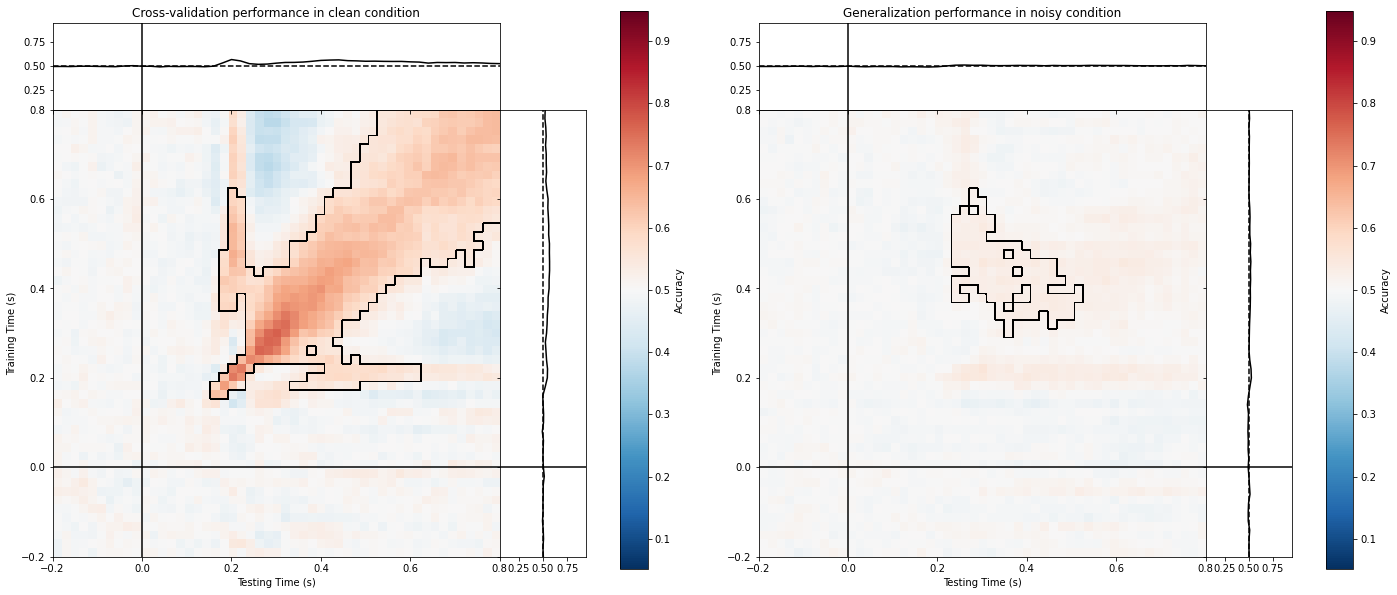

In [11]:
times = np.linspace(-200, 800, 51) / 1000     # Enter times in ms
interpolation = "antialiased"
chance = 1/2
mask_mode = "contour"
p = 0.05
n_jobs = -1
tail = 1
metric = "Accuracy"
subjects = "all"                             # Set to "all" to use all subjects, otherwise a list of indicies to use
plot_noise_levels = False

if subjects != "all":
  clean_scores_tmp=np.array(clean_scores)[subjects,...]
  noisy_scores_tmp=np.array(noisy_scores)[subjects,...]
else:
  clean_scores_tmp=np.array(clean_scores)
  noisy_scores_tmp=np.array(noisy_scores)

scaling = max(np.abs(clean_scores_tmp-chance).max(), np.abs(noisy_scores_tmp-chance).max())

fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

plot_generalizing_score(ax1, clean_scores_tmp, times, title="Cross-validation performance in clean condition", scaling=scaling,
                        metric=metric, p=p, tail=tail, n_jobs=n_jobs, mask_mode=mask_mode, interpolation=interpolation)
plot_generalizing_score(ax2, noisy_scores_tmp, times, title="Generalization performance in noisy condition", scaling=scaling,
                        metric=metric, p=p, tail=tail, n_jobs=n_jobs, mask_mode=mask_mode, interpolation=interpolation)

fig1.tight_layout()

if plot_noise_levels:
  if subject != "all":
    noise_level_scores_tmp={k: v[subject,...] for k, v in noise_level_scores.items()}
  else:
    noise_level_scores_tmp=noise_level_scores
  
  fig2, axes = plt.subplots(1, n_noise_bins, figsize=(40, 10))

  for (noise_level, scores), ax in zip(noise_level_scores_tmp.items(), axes):
    plot_generalizing_score(ax, scores, times, title=f"Generalization performance in {noise_level/100:02.1%} noise condition", scaling=scaling,
                      metric=metric, p=p, tail=tail, n_jobs=n_jobs, mask_mode=mask_mode, interpolation=interpolation)
  
  fig2.tight_layout()

In [12]:
epochs.metadata

,Unnamed: 0,trigger,noise_pct,keypress_face,rt
0,0,1,NaN,None,None
1,1,2,NaN,None,None
2,2,2,NaN,None,None
3,3,2,NaN,None,None
4,4,1,NaN,None,None
...,...,...,...,...,...
925,625,12,50.0,False,None
926,626,11,60.0,False,None
927,627,12,40.0,False,None
928,628,11,75.0,False,None
